In [2]:
!uname -a

Linux compute-0-25.local 2.6.32-642.el6.x86_64 #1 SMP Tue May 10 17:27:01 UTC 2016 x86_64 x86_64 x86_64 GNU/Linux


In [3]:
!pwd

/home/tallam/plasticc/snmachine/examples


In [4]:
!pip install ../.

Processing /home/tallam/plasticc/snmachine
  Running setup.py bdist_wheel for snmachine ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-1on54q2f/wheels/cd/65/db/fda56ff3f0d6fa8ba1e7b69dab8a17be3a2bbe7940a42d6151
Successfully built snmachine
  Found existing installation: snmachine 1.1.1
    Uninstalling snmachine-1.1.1:
      Successfully uninstalled snmachine-1.1.1


# Notebook for running the snmachine pipeline on PLAsTiCC simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the photometric light-curve astronomical time-series classification challenge (PLAsTiCC). 

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882 for the original SPCC-challenge test.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [6]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack,unique
from astropy.io import fits
import sklearn.metrics 
import sncosmo
import pickle
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Set the number of processes you want to use throughout the notebook
import multiprocessing
num_cpu = multiprocessing.cpu_count()
nproc=num_cpu
print("Running with {} cores".format(num_cpu))

Running with 40 cores


## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

## Initialise dataset object

Load a subset of the PLAsTiCC simulated data (https://arxiv.org/abs/1810.00001)

In [8]:
# Please specify Data root, 
# the path to where you have pulled all the data from
rt='/share/hypatia/snmachine_resources/data/cwp/DDFY1/RH_kraken_2026_ddf_DDF_1aONLY_Y1_G10/'
prefixIa='RH_DDF_1aONLY_Y1_G10_Ia-'
prefixNONIa='RH_DDF_1aONLY_Y1_G10_NONIa-'
# Name for the dataset
dataset='kraken_2026_ddf_Y1'

In [9]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_{}_no_z'.format(dataset),'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

final_outdir="/share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_{}_no_z/".format(dataset)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

In [10]:
dat=sndata.LSSTCadenceSimulations(folder=rt,prefix_Ia=prefixIa, prefix_NONIa=prefixNONIa, indices=range(1,21))
#dat=sndata.plasticc_data(folder=rt,pickle_file='dataset_full.pickle',from_pickle=True)

Reading data...
chunk 01
chunk 02
chunk 03
chunk 04
chunk 05
chunk 06
chunk 07
chunk 08
chunk 09
chunk 10
chunk 11
chunk 12
chunk 13
chunk 14
chunk 15
chunk 16
chunk 17
chunk 18
chunk 19
chunk 20
0k
10k
20k
30k
33862 objects read into memory.


In [11]:
# Get the types, note these are internal snmachine datatypes
types=dat.get_types()

Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

In [12]:
# Like for SPCC example notebook where we restrict ourselves to three supernova types:
# Ia (1), II (2) and Ibc (3) by carrying out the following pre-proccessing steps
types['Type'] = types['Type']-100

types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3
types['Type'][np.floor(types['Type']/10)==4]=3

<IPython.core.display.Javascript object>


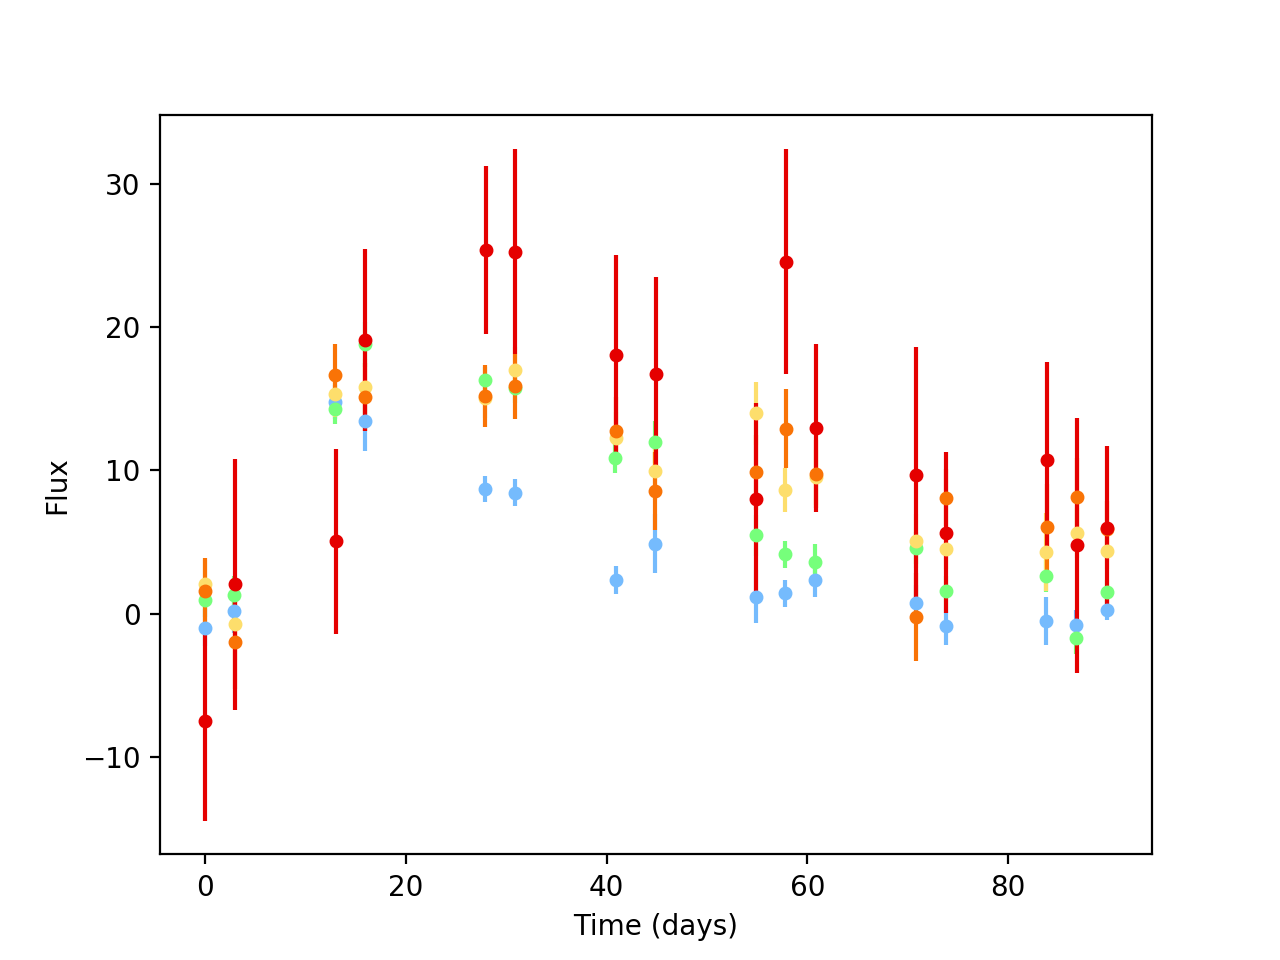

In [13]:
dat.plot_all(mix=True)

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

Note: The types listed here in the table the internal types to snmachine

In [14]:
dat.data[dat.object_names[0]]

mjd,flux,flux_error,filter,zp,zpsys
float32,float32,float32,str5,float64,str2
0.0,0.988641,1.19951,lsstr,27.5,ab
0.0077,-0.975558,1.30056,lsstg,27.5,ab
0.0153,2.05631,1.67012,lssti,27.5,ab
0.0262,1.58105,2.30114,lsstz,27.5,ab
0.0372,-7.49958,6.95352,lssty,27.5,ab
2.9162,1.31818,1.3244,lsstr,27.5,ab
2.9238,0.163389,1.49932,lsstg,27.5,ab
2.9315,-0.705265,2.55051,lssti,27.5,ab
2.9424,-1.95259,3.32448,lsstz,27.5,ab


## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

In [15]:
read_from_file=False #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'{}_all'.format(dataset))
read_from_pickle=False
pickle_location = rt
restart_from_GP = False
restart_from_wavefeats=False
restart_from_wavelets=True

### Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [16]:
#waveFeats=snfeatures.WaveletFeatures()
wavelet_feats=snfeatures.WaveletFeatures(wavelet='sym2', ngp=100)

In [17]:
%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
elif read_from_pickle:
    print('THIS IS NOT CURRENTLY IMPLEMENTED')
    f = open(rt)
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
elif restart_from_GP:
    wave_features=waveFeats.extract_features(dat,nprocesses=nproc,output_root=rt,save_output='all',restart='gp')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean
    
elif restart_from_wavefeats:
    wave_features=Table.read(rt  + 'wavelet_features.fits',format='fits')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    f = open(rt+'PCA_eigenvals.pickle','rb')
    PCA_vals=pickle.load(f)
    f.close()
    f = open(rt+'PCA_eigenvectors.pickle','rb')
    PCA_vec=pickle.load(f)
    f.close()
    f = open(rt+'PCA_mean.pickle','rb')
    PCA_mean=pickle.load(f)
    f.close()
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,PCA_vals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,PCA_vec)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,PCA_mean)

elif restart_from_wavelets:
    # RESTART FROM WAVELETS
    # Copy int to finaldir and read in raw wavelets
    wavelet_feats=snfeatures.WaveletFeatures(wavelet='sym2', ngp=100)
    wave_raw, wave_err=wavelet_feats.restart_from_wavelets(dat, os.path.join(final_outdir, 'int', ''))
    wavelet_features,vals,vec,means=wavelet_feats.extract_pca(dat.object_names.copy(), wave_raw)

else:
    wavelet_features=wavelet_feats.extract_features(dat,nprocesses=nproc,output_root=out_int,save_output='all')
    wavelet_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,wavelet_feats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,wavelet_feats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,wavelet_feats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean

Restarting from stored wavelets...
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2263625 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1323829 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2011155 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1315611 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2866740 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_krake

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2946656 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1845987 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_827365 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_580200 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2081085 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_215509

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1292927 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_998033 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1966271 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_316496 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_575536 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2417780

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1287823 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3012121 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_686383 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_627880 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_558803 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1195603

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1194301 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_249884 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2481882 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_275712 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_713367 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2930098

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2553473 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2345320 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2990213 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_614862 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2509173 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_87385

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3131076 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2254710 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1828187 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2641755 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_37124 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_300837

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_945994 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3020245 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_723122 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3064389 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3009232 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_91597 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1656317 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1698482 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_251452 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1045006 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1750937 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_13815

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1765863 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1212699 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1948416 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2090116 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1621532 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_6931

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_853317 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1115604 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2219256 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_905756 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_357022 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2819427

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1345710 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1640085 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2477211 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2538824 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_398434 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_16111

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1445759 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1376569 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1559146 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1119696 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_111999 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_94066

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_172164 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1391257 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1050725 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_289729 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_567808 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2895596

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2813995 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2138835 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_161126 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_50360 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1648105 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3165939

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_929142 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_675500 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1201621 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1611654 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_972503 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2718500

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1837945 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2466694 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_620106 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1606675 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2492715 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_21159

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2365526 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2142222 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_264825 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3174162 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_733453 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_111772

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_413810 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3094865 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2471847 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_662157 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_890578 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1799298

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3118009 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1888084 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_304880 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2520149 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_616020 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_190211

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_484148 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_808457 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_505212 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3045050 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_836017 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2370080 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_921155 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2483898 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2168886 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_103114 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_637168 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1628688

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1170294 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3217139 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_716545 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_509996 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1755414 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_114972

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_493646 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_681882 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_209552 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3021791 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_704966 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3188476 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1692115 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2378901 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1589162 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_843994 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3201525 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_15627

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2337761 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2477149 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1527774 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2225497 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2109135 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1999

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_260964 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2650957 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1727720 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_915858 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2246712 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_303670

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2681659 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1674097 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1937019 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2852650 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_649430 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_28868

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2121958 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2113537 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_138837 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_490095 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_293744 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2146184

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1799106 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_792718 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_504416 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_100731 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2304704 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2580770

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2562665 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2300655 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2233900 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3211862 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_249971 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_15234

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_586412 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2522671 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_599079 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2972984 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2574172 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_141688

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3146182 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3177807 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_689555 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2392311 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_855882 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_62479 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_315215 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_566784 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2563909 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2545446 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2912906 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_173056

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3108562 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2606226 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1870802 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2382477 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1739850 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3194

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1512508 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_413864 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_728724 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_141150 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1681431 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1166930

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2513132 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_953291 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_245905 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3116117 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_195108 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_9695 do

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2562876 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2188412 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2210072 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2269082 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_595268 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_60126

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2236446 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1052234 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1423172 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1234374 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2535773 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1026

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1729960 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_883741 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1162283 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1757305 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2325125 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11453

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1058086 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1153552 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1873821 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3121685 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1999570 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3967

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2553015 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2037891 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2633088 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_566430 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3017743 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11081

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1728254 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2695170 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1010919 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1856507 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1648074 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2835

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2053446 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2731094 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2218213 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1062942 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3084038 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2632

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2880672 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1866372 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1498013 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2778795 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2583362 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3910

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1358612 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_623860 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1902523 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2727190 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1227479 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11648

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3160075 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_732284 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1747140 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_551164 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2438106 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_199762

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1065221 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3010334 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1391939 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2523871 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_752469 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_95061

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2515435 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2104030 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2471861 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2037412 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_638799 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_53550

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1062962 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_679115 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2392406 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_594263 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1613853 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_240620

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_571210 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_320568 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1975855 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1534814 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1703208 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_537705

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2547824 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2208999 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1724710 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_140931 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1733718 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_36230

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1780812 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3127425 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_604359 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1802768 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1098436 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_17199

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_301227 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2207289 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1387013 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2804251 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1410605 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_27676

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_28039 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2589783 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3025248 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1773617 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_531006 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1396784

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1905616 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2571768 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2365242 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1162582 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_58277 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_184728

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2224141 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2334461 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1534149 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2942270 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1731007 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1158

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2135421 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2813626 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1301412 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_966669 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2265993 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_33138

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1823633 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2449289 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_402450 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1497916 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3207516 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_25231

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_696903 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2066312 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_512737 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_961643 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2529779 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1355005

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1640902 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2139398 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2188459 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_397085 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1357852 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_18194

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1201632 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2057425 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1278104 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3014349 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2197460 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1493

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2459616 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_814299 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1089653 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_279476 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2368901 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_190413

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2279514 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2645680 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1271476 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1054419 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2786587 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2965

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_929038 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3041958 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_213634 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2722958 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2739026 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_164806

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2897174 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2657715 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2913689 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1283116 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_862784 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11898

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_176659 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2102701 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2868762 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1521417 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1535993 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_14127

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3030161 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_242545 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2260789 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_296553 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3105739 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_137222

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2054342 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_751467 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2691695 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1553295 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2783797 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_76069

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1221448 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2137748 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_837462 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_760277 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1700714 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_933792

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1644140 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3159529 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2050370 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2559478 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1131909 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1280

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2475414 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1975235 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2840656 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2117974 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_981946 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_27701

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2079799 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2222054 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1426170 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1164778 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_262695 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_23935

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2746942 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_672703 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_466275 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2685842 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2814255 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_107563

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2269738 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2480419 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1868885 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2333094 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1733114 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_7546

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_634990 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_904246 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2705178 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1175504 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_149564 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2218253

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1788703 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1776486 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_818172 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2618282 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1406959 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_54748

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1767063 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_849507 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1437830 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1270990 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2863593 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_86652

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1185161 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_402231 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_237952 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1488381 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1238929 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_597229

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1265784 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_585713 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2556658 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2528622 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1142483 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_25488

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2507513 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1755261 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2023671 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1898765 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_358870 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_21684

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2531071 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2848645 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_810962 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_210968 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3198500 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_139927

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1585896 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2983785 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_549679 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1574051 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_470754 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_236058

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_243340 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_855978 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1975196 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2103133 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2464470 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_207074

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1693320 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_161492 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1480548 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2840236 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_517235 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_295530

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_423341 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1800558 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2833564 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3156486 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_842671 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_794381

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1906753 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_535154 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_732662 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_99604 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_923881 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1083064 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1161674 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2995952 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2311514 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1668630 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1736121 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2622

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1030439 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1929843 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1068138 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_420619 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_542656 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_278796

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_318943 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1644914 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2454425 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1052290 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3054745 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_24730

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1354447 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2221825 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_900790 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_10274 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_663434 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_723614 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3204596 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1241059 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2462127 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2223318 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1564533 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_8823

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3079475 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3878 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2790893 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2619713 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_225887 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1375657 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1005402 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3009448 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1238809 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1167366 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1039921 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1069

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3162824 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3014782 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2101668 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1385993 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_110588 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_83136

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1184137 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2085302 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1064578 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1798353 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_537299 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_27685

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1062791 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1906015 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2993108 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2691061 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3165266 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1923

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1803892 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2126686 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_505442 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2942921 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1160879 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_49614

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1129448 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2846992 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1048397 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_142842 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2955245 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_26864

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2064854 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_702422 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2180647 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1456689 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2687310 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_27193

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_816242 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2615062 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_998450 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1176468 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_354381 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3016219

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_376036 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1343401 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_673104 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2574634 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3152838 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_305352

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_495958 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1213440 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2153578 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1593053 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2560591 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_51468

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1718691 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_60316 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1810824 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2617347 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1292179 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_125690

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3091982 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1755145 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_596856 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_788623 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3211874 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_240288

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2633125 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1668113 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_893278 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_498483 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2487371 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_212304

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2920814 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11239 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1081953 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_441042 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2955797 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2561986

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1156414 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_8824 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_686657 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1365483 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3102947 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1998137 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2554744 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_199608 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1006158 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1397265 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1582138 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_21768

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1964068 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1268067 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2708150 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_861602 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1052613 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_64871

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1466736 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2688490 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2446004 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_327630 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_978927 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_988067

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_537776 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2862489 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1678704 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2545764 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2574461 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_36721

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3040753 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2205674 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2030778 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_251547 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1267131 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_12360

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_242939 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2271165 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2195063 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1196169 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1050660 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_56681

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1924760 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1442556 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2774685 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_678842 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_104839 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_281509

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1703994 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2861584 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_979025 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2207633 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_988371 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_229776

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1057750 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_316598 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2630420 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2262360 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1272819 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_27451

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1271383 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2512648 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2239387 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_13602 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1315552 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_248488

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_298241 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_738129 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2451480 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3105610 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_327266 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_240645 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3174408 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2763664 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2082025 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_271806 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_310183 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_168693

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_790525 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_446970 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1990717 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1827876 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1710492 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_256272

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1739586 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2636393 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2793514 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1581144 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2686839 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3529

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1858145 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1567342 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_926172 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_945112 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2355779 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_228377

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1588094 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_231657 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3067751 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1739870 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2648888 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_77404

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2150141 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2470056 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2906034 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_265310 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2705274 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_14963

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_758968 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1643431 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_440629 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1507863 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1421905 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_546976

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1581473 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1792940 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1192309 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1872496 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2577808 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2261

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2613810 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_157207 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_825256 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_779209 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_512139 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_147861 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_762169 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1741747 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_27304 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3211096 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2140246 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_276983 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1633961 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1996358 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_279117 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_648209 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2789100 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_267115

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2947172 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1103368 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1938871 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_539409 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1227591 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_14803

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2930390 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2740704 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2391864 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_587622 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1846321 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_29615

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2797521 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1568550 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2331137 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1510123 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1453005 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2510

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_257680 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2407936 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1937983 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1503759 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_633537 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_125189

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1268657 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2720826 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_461284 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2482489 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1490471 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_75479

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1061538 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_141438 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2144258 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1926219 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2944265 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11594

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3035345 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_439649 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1671924 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1584068 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1769731 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_29325

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_844949 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_645185 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_259436 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2437037 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1764956 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1868507

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2690795 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2754982 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2984177 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3028348 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1401348 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2071

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_53906 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2315687 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_670461 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2505522 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2781382 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1822675

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1664614 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_42274 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2909502 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1112611 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_382645 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2934952

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1664324 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2918533 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_548520 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2735970 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1449540 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_32103

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1867597 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2071380 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1930439 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1714951 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1960022 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2094

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_708940 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1963014 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2612894 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_926496 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_541666 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2702934

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2006639 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1231387 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2439559 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2980809 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2950160 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2943

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1481995 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2282858 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_716270 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_415901 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1285203 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_523446

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1884505 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1678067 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1259715 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2631813 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_252400 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_70574

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_958933 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1667183 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2515070 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3135631 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2297636 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_16262

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_919583 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2935926 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_817869 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1394287 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2782491 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_575103

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1983492 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1639674 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_812582 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_415340 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2572160 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_880374

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1808659 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3038420 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_854337 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1711941 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3167827 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_48035

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_898268 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_616393 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2432457 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_777256 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1196167 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_585562 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1293025 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1405633 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2547223 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1742881 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1757011 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2368

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2889709 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_322193 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1247938 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1488296 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1828882 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_17190

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2070777 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2377296 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_477445 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1666696 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1056283 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_27843

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3133253 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_383353 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2284498 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2588555 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2702226 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_28323

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1339377 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2013772 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2229405 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2016179 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_368185 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_95985

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2709632 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_776321 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_677233 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3182259 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1632349 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_279691

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_113850 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1653739 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1030461 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_512215 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2421299 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_192091

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_811775 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_985796 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_916457 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2226982 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1601580 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1482639

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_259151 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2820810 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_782132 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2366515 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2955350 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_125203

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_325745 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_860323 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1124800 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1921290 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2695128 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_297835

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1949650 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_308846 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_902034 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1097943 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2109518 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_180469

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_585680 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_921586 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_385306 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1737885 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2479148 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2437696

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3122609 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1326947 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1834367 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_630401 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1049296 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_31232

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2461997 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1044301 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2556269 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1058928 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2807271 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_8479

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_436010 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_621313 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_113682 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_191512 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2766706 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1658914 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_793718 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2395979 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2084870 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1201572 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_471379 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_100647

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_505599 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1645480 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1428367 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2611231 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2498131 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_26149

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_492001 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2957117 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3071341 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_479177 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_771587 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1889544

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2087681 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_70107 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_88251 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2079414 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2773420 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_837709 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_77482 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1345697 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_788686 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2748438 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1825825 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_380326 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_504728 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2700417 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_48482 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_681890 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1776958 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1369076 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2352890 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_798652 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1218590 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2523594 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1525190 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_14067

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_970647 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3101171 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2066234 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3126945 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_862895 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_313765

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1197128 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2733497 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_699234 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_471245 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1960921 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_59059 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1879231 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2025644 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_30007 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_201346 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_671887 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_297965 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2975649 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_742332 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2001758 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1754980 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1317566 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_16457

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1733208 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2629303 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1804504 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_707181 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3176752 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_23249

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1592675 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2803277 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_167667 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2650835 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_283494 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_841472

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3086369 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1648910 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_510500 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_124308 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2740779 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_66138 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2169370 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2624313 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3106168 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3148965 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2313087 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1544

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3030512 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3170449 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1579030 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2896423 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_234241 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_22347

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1883088 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1605954 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1749662 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2283108 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2888829 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1655

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_310846 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2073710 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2749952 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_16932 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2514409 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_589240 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_44377 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_63220 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1260636 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1185029 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2208233 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_405237 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_108125 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2075459 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1312384 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1862119 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2802506 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_26794

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2996747 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1411030 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2196773 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_626145 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_838485 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_152011

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2633336 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2508334 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3168393 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1851023 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2167665 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1104

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2088801 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1776017 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_608775 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_189520 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2964737 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_103952

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_554758 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2733913 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1035349 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3043634 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2529231 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11127

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_922983 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_209846 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1959180 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1232506 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_408185 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3169495

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2916605 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_811273 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1290502 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2960552 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3179037 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_82791

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1657901 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_843559 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2135388 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_379190 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2181994 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_106074

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2188280 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2041741 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_374654 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_350410 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_571337 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_830682 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_436485 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1397465 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2835452 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1520320 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2149968 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_51981

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_624455 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_563447 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1807700 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1168481 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_628495 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_89685 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_216408 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2570128 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2927502 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2848490 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1161238 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_19283

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_79074 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1558055 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_140497 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_553565 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1933274 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_346808 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1654353 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_44176 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_793584 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_770180 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1719594 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1160679 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1438929 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_72740 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_939513 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1303731 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_303233 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2238048 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2561671 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1076849 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2205590 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1853020 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1595057 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3033

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_859999 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_761169 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2624800 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3074048 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1704933 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_876921

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2282449 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1240006 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1856361 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_629444 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_201546 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_202220

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1291834 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2135964 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2524358 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2758230 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2839774 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2895

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1921421 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2065362 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1035898 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3209473 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_576505 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_91441

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2640777 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2710877 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_813229 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3024140 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1933551 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_84295

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2803750 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2567479 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2069128 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_345735 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2108436 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_10862

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2638120 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3140066 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2100986 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2440902 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2076246 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1942

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1253518 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_62231 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1621159 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2966844 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1951816 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_276820

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1250214 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2657655 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_784868 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3186146 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1694689 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_18922

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_8673 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2400678 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_181602 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1888849 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1849236 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1994220 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2572236 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_549193 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2220193 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1334926 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1073080 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_15352

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_786012 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3147354 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_194277 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1845647 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_645890 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2044143

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2690054 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2654018 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1943641 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2738673 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_118244 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_22560

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_266460 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1950220 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1693256 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1479488 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1946079 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_49967

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2806406 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2670610 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2687900 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2069655 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1228699 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_4022

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2373728 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1802318 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3056058 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2940777 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2310503 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2900

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1038824 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_462779 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1546041 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_960650 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3030137 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_236278

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2837619 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_863736 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_154292 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1214490 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1980966 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_234913

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2774681 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1529577 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1915125 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_638559 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_987038 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_149912

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_747511 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_384822 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_886235 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_968474 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2265372 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2399958 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1780475 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2598409 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1304826 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_987148 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1756918 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11583

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2554605 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1650139 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2775488 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_475598 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2604412 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_28632

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3211491 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1007035 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1246181 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_60315 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1521207 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_114374

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1432083 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_785411 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1200559 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2108155 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_636557 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_724167

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_951600 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2392404 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2485233 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2505125 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2566547 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_25006

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2375016 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_59335 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_702417 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2188018 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1333576 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1958825

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2114258 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_568308 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_648490 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2684049 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_929862 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2813982

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1999448 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1931366 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1990822 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3083543 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2926613 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2898

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2238916 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2291941 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_132147 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1690757 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3202162 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_83657

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3203387 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2875760 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_251158 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1541905 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_986279 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_277245

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1506623 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3189409 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1451375 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1582490 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3118196 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1364

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_444827 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_243327 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_562790 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1162915 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1588571 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_580213 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2419772 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2273929 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2850154 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1903485 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1959233 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2743

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_960590 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_499630 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2065949 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_346026 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_636122 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_291720 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2599348 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2146861 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1930906 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2476534 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_883466 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_93043

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_687691 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_145023 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2204349 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_407138 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1680072 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1608934

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_878943 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2801882 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_743592 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_646370 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1062931 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_555109 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1142933 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_148407 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_22054 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2818775 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1586543 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1896155

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_174161 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1119170 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_22923 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2844750 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1498563 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2154360

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_254672 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_680587 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2510967 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1411082 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2966183 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_220073

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_917487 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1273898 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_746515 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1678220 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1351092 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_555117

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_728238 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_900442 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_478618 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_63129 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_715808 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2043811 do

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2505181 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2442896 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_543496 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_968278 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1490858 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_251917

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1229606 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_115569 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1243489 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_221175 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2282965 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_650281

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_913845 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1566648 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_95720 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1718764 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_979581 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_545660 d

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1193137 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2289591 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2635839 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_572746 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1446828 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_20167

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1782322 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1584067 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2401219 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_950425 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2987726 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_20934

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2836236 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1288501 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_371688 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1177921 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1253746 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_29789

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2886888 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_935242 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1566107 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1466675 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_91881 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_913819 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2559263 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2078678 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3081760 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2261361 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1068895 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1375

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2571811 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1220594 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_875481 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3146539 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2905590 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_25999

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2244599 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2036199 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2996426 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1914585 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1460396 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2388

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2450914 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_548694 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1519438 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_688059 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1782141 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_103919

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_375849 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2881161 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_677281 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_718129 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2796897 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2532001

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1781245 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2207074 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_792381 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1002231 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1406761 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_15930

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2845615 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2035474 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2459653 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1261760 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_753825 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_28048

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2756788 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_570925 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_666002 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2253133 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_838595 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_547761 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2027930 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1778667 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1959594 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1007580 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1153045 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_9289

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3178812 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_241134 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2412841 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2596299 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2401424 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_24472

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3172626 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_356053 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_172573 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1083828 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1540948 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_128293

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_952270 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1711057 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3179288 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_340893 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3157648 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_146235

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2097169 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2437391 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_519424 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1245465 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_175422 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_837407

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2465144 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_392644 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1762970 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_686162 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2759692 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_213478

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_562305 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_595796 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_844543 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2004487 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2400751 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1494450

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3047375 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_930164 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_315372 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1321955 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2631766 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11420 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2599580 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1252857 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_664114 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1640377 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2392274 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_13954

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2902690 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3214958 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_267184 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2404612 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3092167 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_23042

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2128309 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1791054 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2619693 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2503221 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2003761 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_9264

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1147225 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1747265 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2755646 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_584578 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2490451 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11129

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2311642 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1192985 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2072302 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_446888 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1543257 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_25546

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2162856 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_23401 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_487563 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3185145 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_3048990 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_985419 

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_46370 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_828482 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2810481 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2948318 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2439878 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1518315

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2635164 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_612926 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1348224 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1572603 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_986990 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_314545

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2278696 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_283552 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1903796 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2750979 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2854614 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_88083

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_717046 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1679132 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1434231 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2421701 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1194733 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_11279

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_702877 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2417010 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_342929 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2179017 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1260379 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_241683

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1919508 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_2057285 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_262595 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_117633 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1498730 does not exist.
IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_308240

IOError, file  /share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_kraken_2026_ddf_Y1_no_z/int/wavelet_1289356 does not exist.
Running PCA...
Time for PCA 35.846269607543945


In [19]:
wavelet_feats

In [20]:
#dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)
dat.set_model(wavelet_feats.fit_sn,wavelet_features,vec,means,0,dat.get_max_length(),dat.filter_set)

Fitting transient models...
Models fitted.


<IPython.core.display.Javascript object>


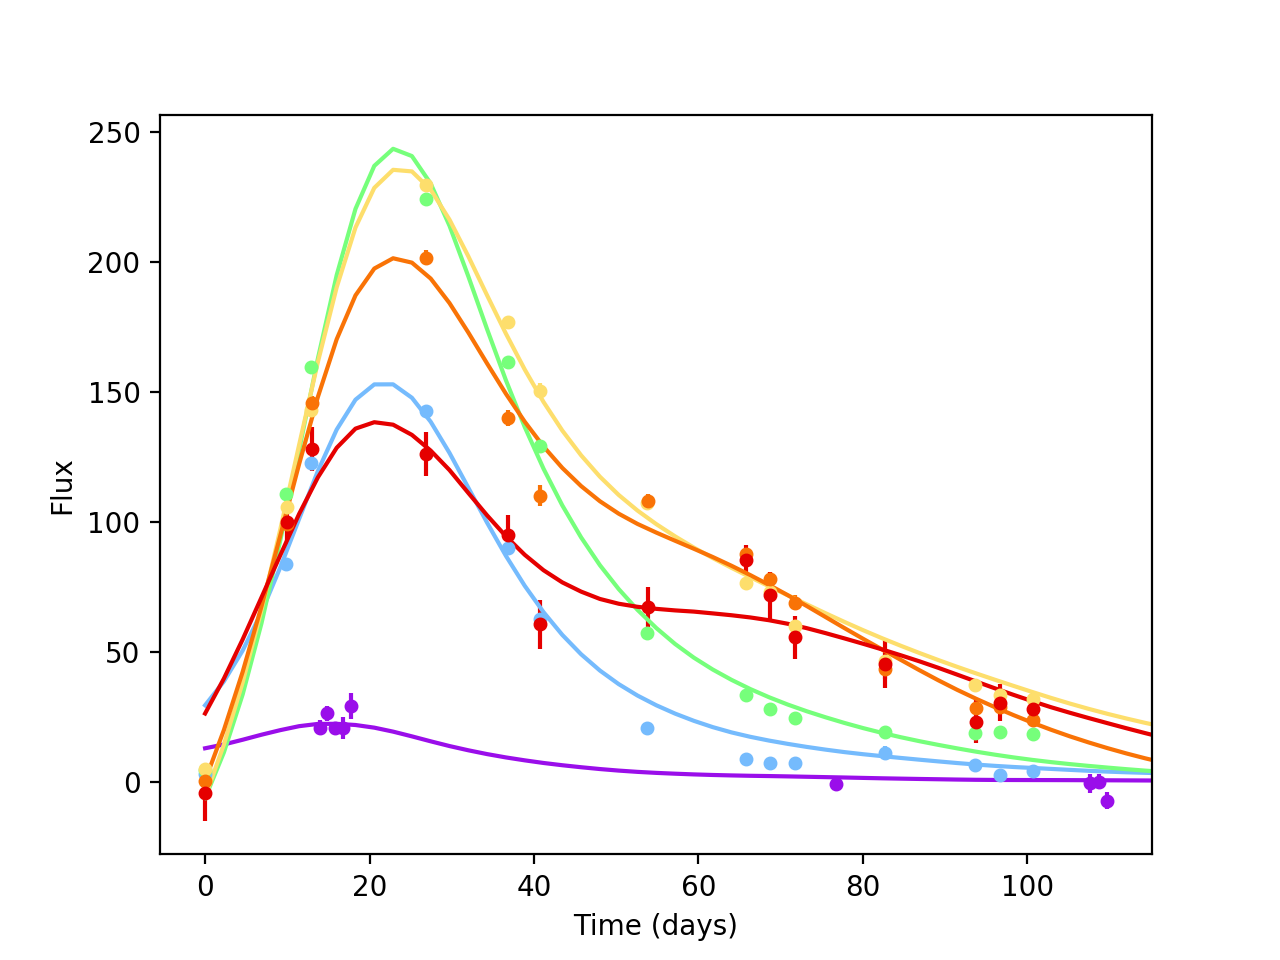

In [21]:
dat.plot_all(mix=True)

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [22]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

['svm', 'knn', 'random_forest', 'decision_tree', 'boost_dt', 'boost_rf', 'nb', 'neural_network']


### Combine further features

<IPython.core.display.Javascript object>


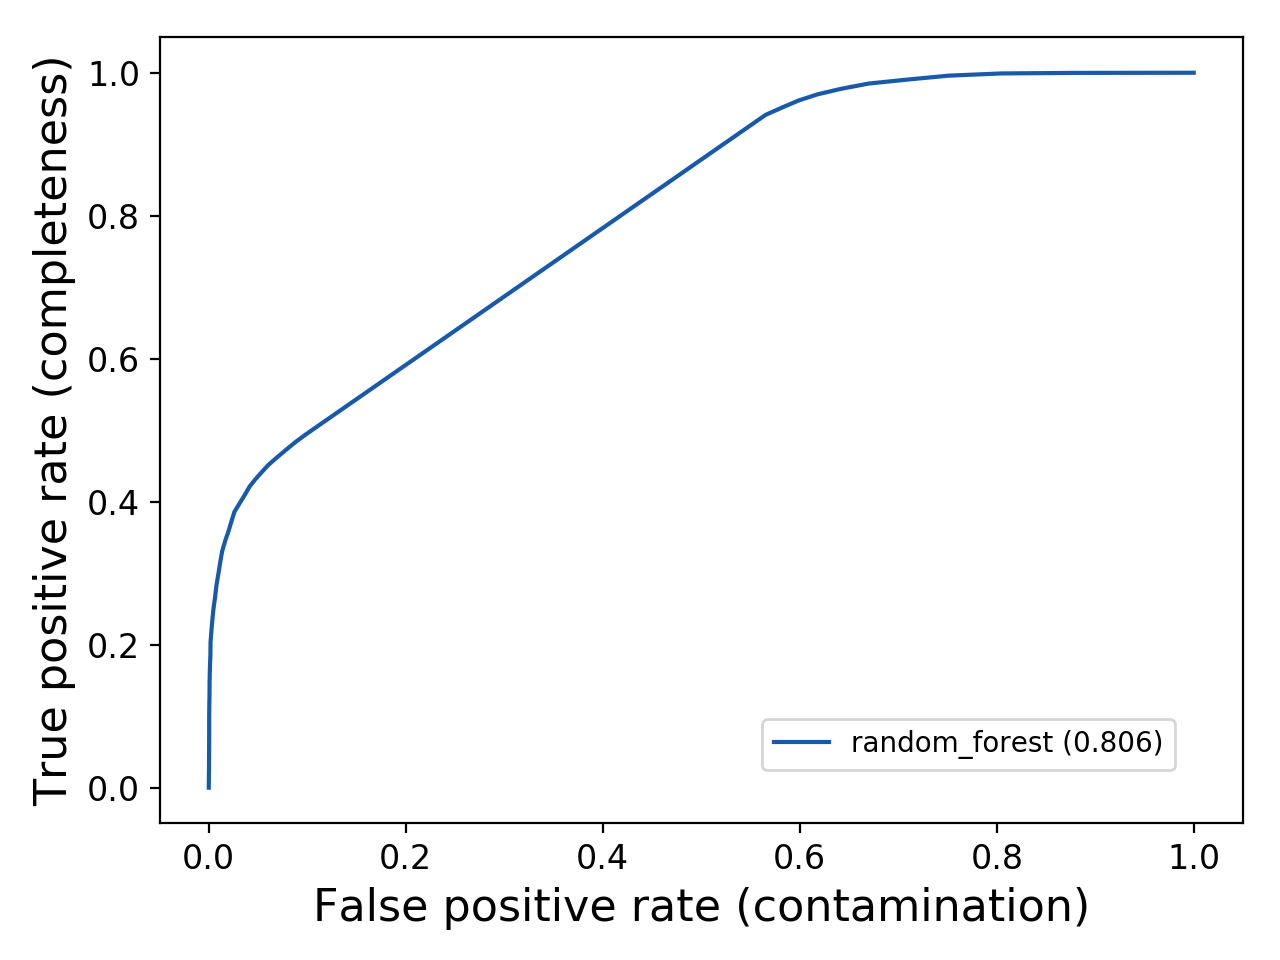

Due to limitations with python's multiprocessing module, classifier objects cannot be returned if multiple processors are used. Continuing serially...

Created classifier of type:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Optimised parameters: {'criterion': 'entropy', 'n_estimators': 500}
Classifier random_forest: AUC = 0.805764342059 FoM = 0.229120678629

Time taken  21.132643751303355 minutes


/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/snmachine/snclassifier.py:130: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(cols)


In [24]:
fig = plt.figure()
clss, cms=snclassifier.run_pipeline(wavelet_features,types,output_name=os.path.join(out_class,'wavelets'),
                          classifiers=['random_forest'], nprocesses=nproc, return_classifier=True,
                              classifiers_for_cm_plots='all')

In [25]:
import seaborn as sns
from astropy.table import Table,join,unique

<IPython.core.display.Javascript object>


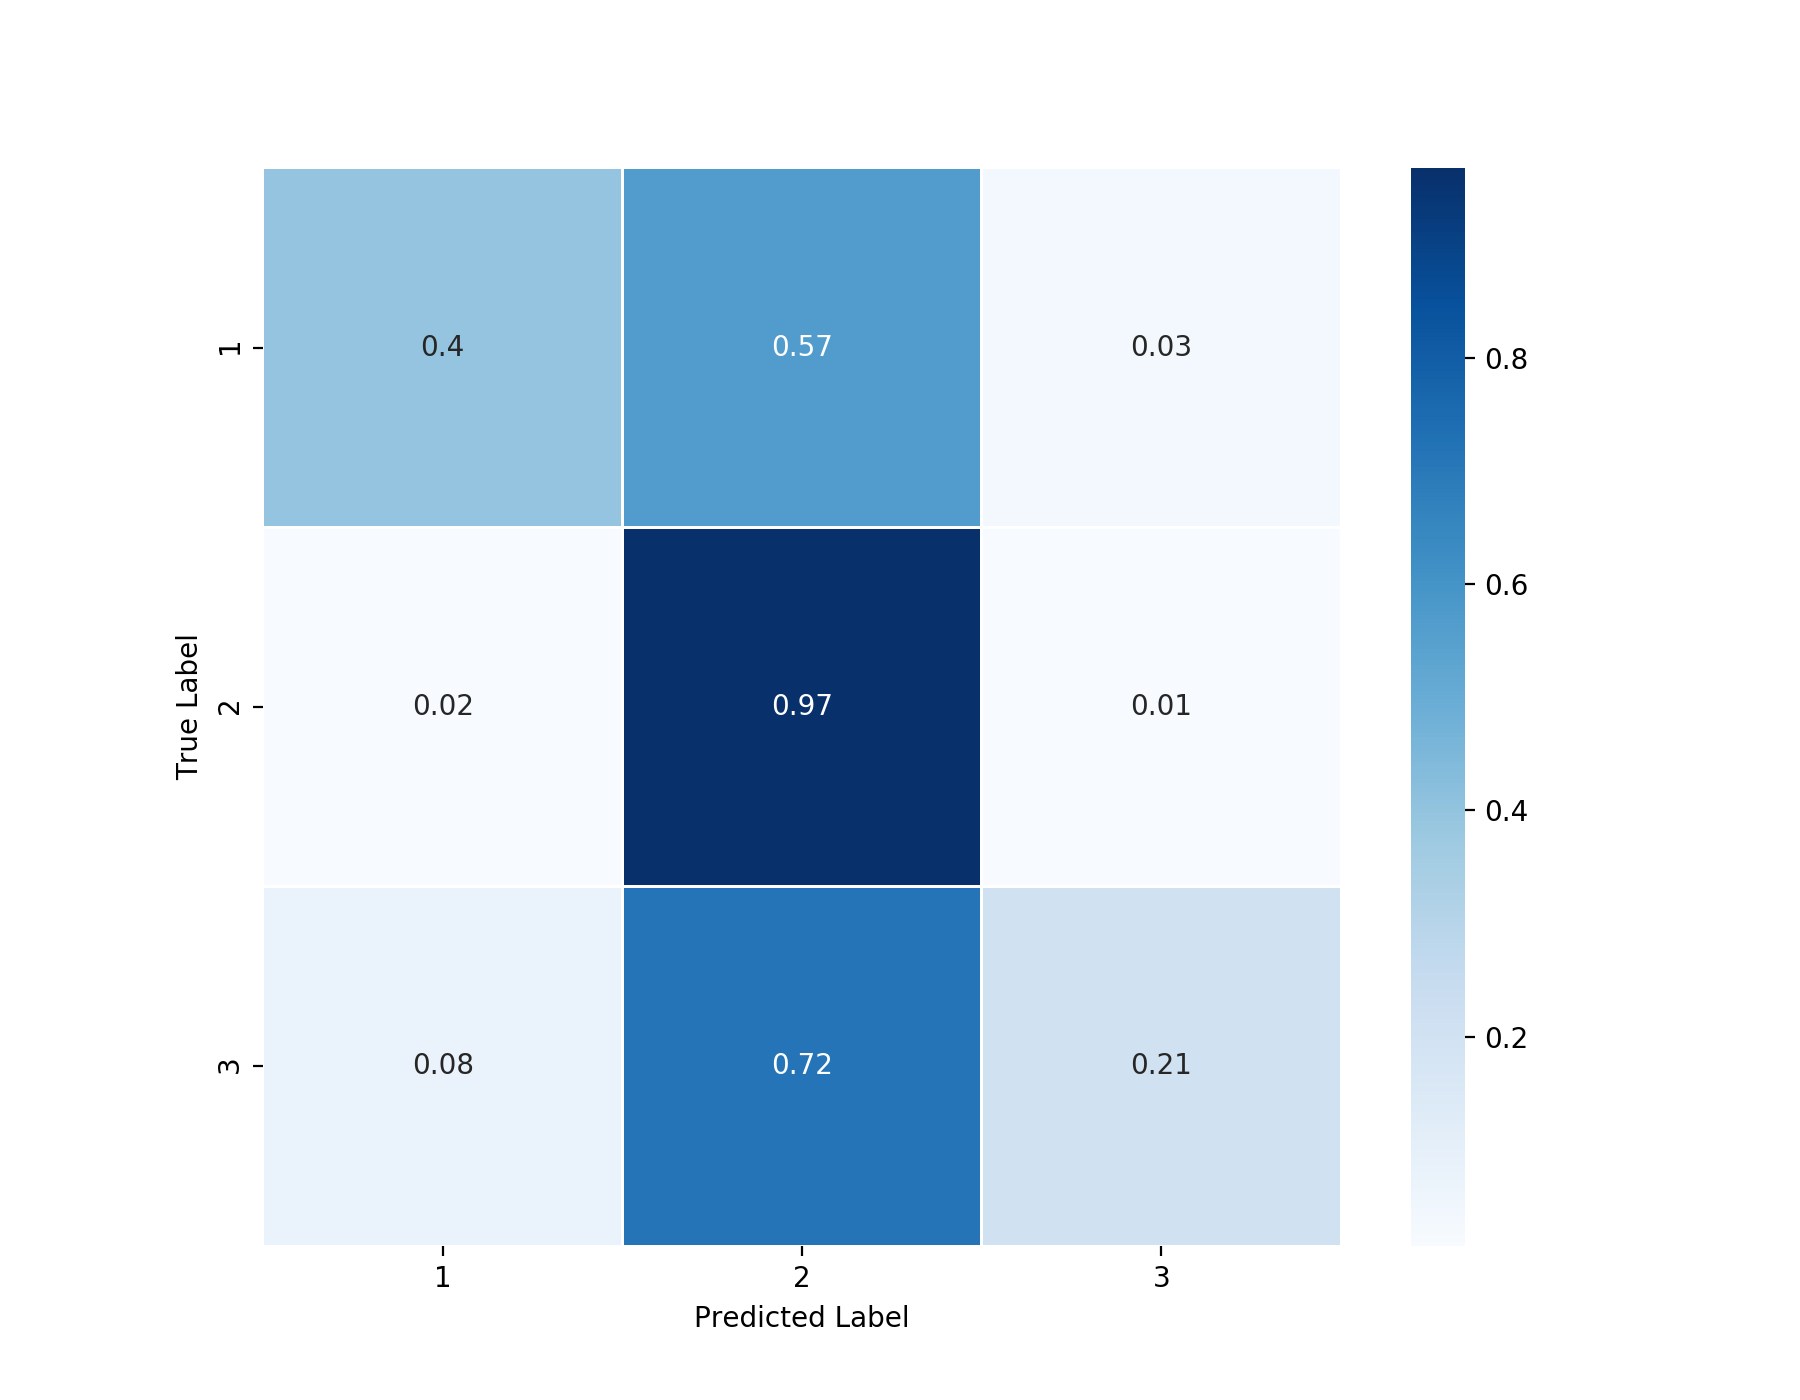

In [26]:
cm = cms[0]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

labels=[]
for tp_row in unique(types, keys='Type'):
    labels.append(tp_row['Type'])

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')